In [1]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from astroquery.simbad import Simbad
import arviz as az

plt.rcParams['figure.facecolor']    = 'white'
import pandas as pd    
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
# from utils import *

07_14_25


In [2]:
import sys
# sys.path.append('/path/to/the/folder/of/your/module/file')
sys.path

['/Users/maryumsayeed/Desktop/Code/Research/espresso_lirich/scripts',
 '/opt/miniconda3/lib/python39.zip',
 '/opt/miniconda3/lib/python3.9',
 '/opt/miniconda3/lib/python3.9/lib-dynload',
 '',
 '/opt/miniconda3/lib/python3.9/site-packages',
 '/opt/miniconda3/lib/python3.9/site-packages/certifi-2022.9.24-py3.9.egg',
 '/opt/miniconda3/lib/python3.9/site-packages/ipython_genutils-0.2.0-py3.9.egg',
 '/opt/miniconda3/lib/python3.9/site-packages/fits2hdf-1.1.1-py3.9.egg',
 '/opt/miniconda3/lib/python3.9/site-packages/IPython/extensions',
 '/Users/maryumsayeed/.ipython']

In [3]:
#pip install thejoker

In [4]:
import thejoker as tj
import thejoker.units as xu
from utils import PLOT_PARAMS
import pymc as pm
import corner
import arviz as az

In [5]:
#p112 = glob.glob('../data/spectra/*.fits')

In [6]:
files = glob.glob('../data/P113_data/*.fits')
# files = glob.glob('../data/spectra/*.fits')

In [7]:

hdul = fits.open(files[0])
header  = hdul[0].header

In [8]:
def get_galah():
    galah =(Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits',format='fits'))#.to_pandas()

    dr2_ids = np.array(galah['dr2_source_id']).astype('str')
    dr3_ids = np.array(galah['dr3_source_id']).astype('str')
    
    galah.remove_column('dr2_source_id')
    galah.remove_column('dr3_source_id')
    galah = galah.to_pandas()

    galah.insert(2, 'dr2_source_id', dr2_ids)
    galah.insert(3, 'dr3_source_id', dr3_ids)
    
    galah['ph_qual_wise']=galah['ph_qual_wise'].str.decode("utf-8")
    return galah
galah=get_galah()

In [9]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

In [10]:
# spectrum = fits.open('../data/spectra/archive/ADP.2023-12-08T12:58:09.704.fits')
# header = spectrum[0].header
# data   = spectrum[1].data

In [11]:
# instrument precision: cm/s
# decription of columns: https://ftp.eso.org/pub/dfs/pipelines/instruments/espresso-das/espda-reflex-tutorial-1.3.7.pdf
# QC CCF RV: computed radial velocity [km s−1

In [12]:
# from: https://www.eso.org/rm/api/v1/public/releaseDescriptions/176
# Barycentric correction. The wavelengths in the science spectrum are correct to the barycentre of
# the solar system. 

In [13]:
# header.cards

In [14]:
obj_dir = {}
c=3e5 #km/s

for i,file in enumerate(files):
    with fits.open(file) as hdul:
        hdul = fits.open(file)
        header  = hdul[0].header
        #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
        data    = hdul[1].data
        time    = header['HIERARCH ESO QC BJD']
        name    = header['OBJECT']
        obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
        grade   = header['OB_GRADE'].replace(" ", "")
        if grade =='C':
            print('RG',obj,header['OB_GRADE'])
            continue
            
        ra,dec  = header['RA'], header['DEC']
        obs_T   = header['DATE-OBS'].split('T')[0]
        rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
        rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
        sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
        rv_corr = rv_val
        err_corr = rv_err
        # correct for Earth's motion:
#         rv_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value #to convert to km/s
#         err_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value
#         rv_corr = rv_val + rv_corr + rv_val * rv_corr / c  
        #err_corr = rv_err + err_corr + rv_err * err_corr / c  
        
        if obj in obj_dir.keys():
            obj_dir[obj]['rv'].append(rv_corr)
            obj_dir[obj]['time'].append(time)
            obj_dir[obj]['err'].append(err_corr)
            obj_dir[obj]['name'].append(name)
            obj_dir[obj]['grade'].append(grade)
        else:
            obj_dir[obj] = {'rv': [rv_corr], 'time': [time], 'err': [err_corr], 'name': [name], 'grade': [grade]}
            
targets_to_remove = []
for k, v in obj_dir.items():
    if len(v['time']) < 3:
        targets_to_remove.append(k)
for i in range(len(targets_to_remove)):
    del obj_dir[targets_to_remove[i]]
print(len(obj_dir.keys()))

myKeys = list(obj_dir.keys())
myKeys.sort()
obj_dir = {i: obj_dir[i] for i in myKeys}
 

RG 12 C
RG 6 C
RG 3 C
RG 11 C
RG 22 C
RG 15 C
RG 3 C
RG 8 C
RG 3 C
RG 25 C
RG 8 C
RG 22 C
RG 3 C
RG 7 C
RG 23 C
25


In [15]:
new_df = {'RG_id':[], 'galah_id': [], 'obj_name': []}

for k, v in obj_dir.items():
    result_table = Simbad.query_objectids(v['name'][0])
    result_table = np.array(result_table).astype('str')
    
    for i in result_table:
        if 'GALAH' in i: 
            galah_name = i.split(' ')[-1]

    new_df['RG_id'].append(k)
    new_df['galah_id'].append(int(galah_name))
    new_df['obj_name'].append(v['name'][0])
    
new_df = pd.DataFrame(new_df)

new_df = pd.merge(new_df, galah[['sobject_id', 'vbroad', 'fe_h', 'Li_fe', 'ruwe_dr2']], left_on='galah_id', right_on='sobject_id')
new_df['Li_val'] = new_df.fe_h+new_df.Li_fe+1.05

cols = ['RG_id', 'galah_id', 'obj_name', 'Li_val', 'vbroad', 'fe_h','ruwe_dr2']

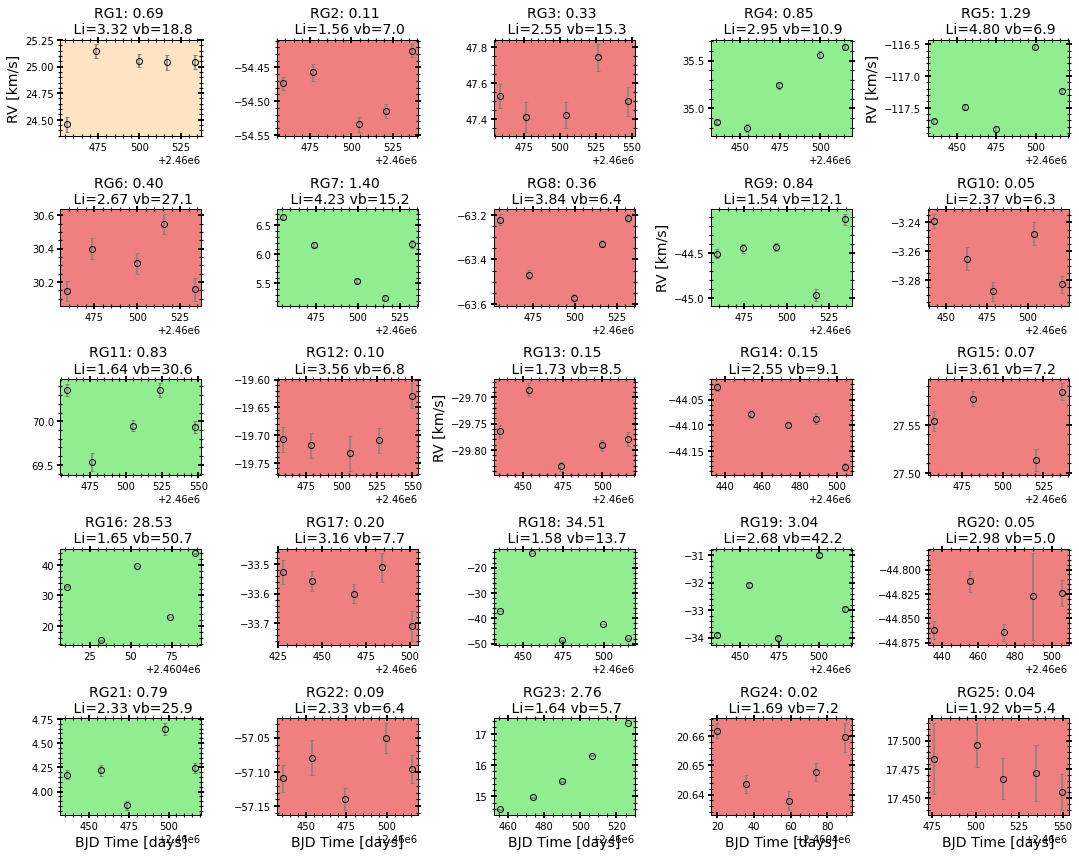

In [16]:
#PLOT_PARAMS(LS=12)

stats = {'RG_id':[], 'A': []}
plt.figure(figsize=(15,12))
for i, (obj, dat) in enumerate(obj_dir.items()):
    if len(dat['time']) > 1:
        #print(obj,obj_dir[obj])
        ax=plt.subplot(5,5,i+1)
        time    = np.array(obj_dir[obj]['time'])
        rv_vals = np.array(obj_dir[obj]['rv'])
        yerr    = np.array(obj_dir[obj]['err'])
        
        if obj != 5:
            mask    = (rv_vals >= -100)
            time, rv_vals, yerr = time[mask], rv_vals[mask], yerr[mask]
            obj_dir[obj]['time'] = time
            obj_dir[obj]['rv'] = rv_vals
            obj_dir[obj]['err'] = yerr
            
        t0  = time[0]
        rv0 = rv_vals[0]
        K0 = (max(rv_vals)-min(rv_vals))/2.
        
        plt.errorbar(time, rv_vals, 
                     yerr=yerr,
                     fmt='o', color='grey', mec='k', mfc='None', capsize=2)
        #plt.axhline(0, color='k',lw=1,ls='dotted')

        diff = abs(max(rv_vals)-min(rv_vals))
        if diff < 0.5:
            ax.set_facecolor('lightcoral')
        elif 0.5 <= diff < 0.7:
            ax.set_facecolor('bisque')
        elif 0.7 <= diff <= 50:
            ax.set_facecolor('lightgreen')

        li, vb = new_df[new_df.RG_id==obj][['Li_val','vbroad']].to_numpy()[0]
        title = 'RG%s: %.2f \n Li=%.2f vb=%.1f'%(obj,diff,li, vb)
        plt.title(title)
        stats['RG_id'].append(obj)
        stats['A'].append(diff)

#         elif title in ['RG4','RG24','RG13','RG7']:
#             ax.set_facecolor('lightblue')
        if i >= 20: plt.xlabel(r'BJD Time [days]')
    if i+1 in [1,5,9,13]: plt.ylabel(r'RV [km/s]')


plt.tight_layout()

stats = pd.DataFrame(stats)

# plt.savefig('../plots/init_%s.png'%DATE, bbox_inches='tight', dpi=200)

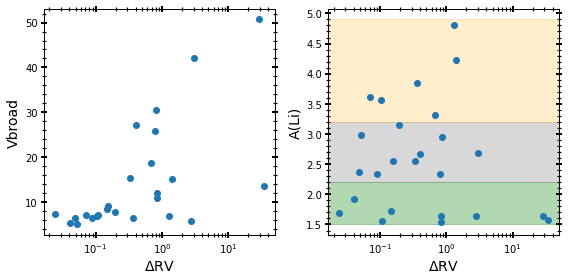

In [17]:
params = pd.merge(new_df, stats, on='RG_id')
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(params.A, params.vbroad)
plt.xscale('log')
plt.xlabel('$\Delta$RV')
plt.ylabel('Vbroad')

plt.subplot(122)
plt.scatter(params.A, params.Li_val)
plt.axhspan(1.5, 2.2, color='green',alpha=0.3,zorder=0)
plt.axhspan(2.2, 3.2, color='grey',alpha=0.3,zorder=0)
plt.axhspan(3.2, 4.9, color='orange',alpha=0.2,zorder=0)
plt.xscale('log')
plt.xlabel('$\Delta$RV')
plt.ylabel('A(Li)')
plt.tight_layout()

In [18]:
def three_body(obj,error=0.1, prior_size=50_000,save=False,MCMC=False):
    data = Table()
    data['bjd'] = obj_dir[obj]['time']
    data['rv'] = obj_dir[obj]['rv']
    print('mean error originally: %.3f km/s'%np.mean(np.array(obj_dir[obj]['err'])))
    data['rv_err'] = np.array(obj_dir[obj]['err'])#*5
    data['rv_err'] = np.array([error]*len(data['rv']))
    print('mean error now: %.3f km/s'%np.mean(data['rv_err']))
    
    t = Time(data["bjd"], format="jd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data["rv"]*u.km/u.s, rv_err=data["rv_err"]*u.km/u.s)
    
    with pm.Model() as model:
        #P_prior = xu.with_unit(pm.Uniform("P", 0.25, 1e3), u.day)
        #M0_prior    = xu.with_unit(pm.Uniform("M0", -np.pi, np.pi), u.radian)
        #omega_prior = xu.with_unit(pm.Uniform("omega", -np.pi, np.pi), u.radian)
        
        #s_prior = xu.with_unit(pm.Normal("s", 0, 0.5), u.km/u.s)
        #K_prior = xu.with_unit(pm.Normal("K", 0, 20), u.km/u.s)
        #e_prior = xu.with_unit(pm.Uniform("e", 0, 1), u.one)
        
        prior = tj.JokerPrior.default(
                P_min = 0.25 * u.day, # to use Joker's default log-normal, give P-min, P-max
                P_max = 1e3 * u.day,
                sigma_K0 = 20 * u.km / u.s,
#                 sigma_v = 100 * u.km / u.s,
                #s = 0.1 * u.km / u.s,
                sigma_v=[100 * u.km / u.s, 
                          0.5 * u.km / u.s / u.day, 
                          1e-2 * u.km / u.s / u.day**2],
                poly_trend=3,
                #pars={'s': s_prior}
                        #'P': P_prior,
#                       #'M0':M0_prior,
#                       #'omega':omega_prior,
#                       #'e': e_prior,
#                       #'K': K_prior, 
        )

    prior_samples = prior.sample(size=prior_size, rng=rnd)
    print(prior_samples)
    
    joker = tj.TheJoker(prior, rng=rnd)

    joker_samples = joker.rejection_sample(data, prior_samples, 
                                           max_posterior_samples=256,
                                           return_all_logprobs=True)
    print(joker_samples[0])
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    _ = tj.plot_rv_curves(
        joker_samples[0],
        data=data,
        relative_to_t_ref=True,
        ax=ax,
    )
    
    ax.set_xlabel(f"BMJD$ - {data.t.tcb.mjd.min():.3f}$")
#     ax.set_xlabel(f"BMJD$ - {data.t.min():.3f}$")
    if save: fig.savefig('../rv_fit/fit_RG%s_%s_2.png'%(obj,DATE),bbox_inches='tight',dpi=100)
    if MCMC:
        
        with prior.model:
            mcmc_init = joker.setup_mcmc(data, joker_samples[0])
            trace = pm.sample(tune=2000, draws=2000, start=mcmc_init, cores=1, chains=2)

        az.summary(trace, var_names=prior.par_names)
        print('MCMC samples...')
        mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data)
        mcmc_samples.wrap_K()
        df = mcmc_samples.tbl.to_pandas()
        colnames = []
        # ==== 3 body ====
        #truth = ['P','e','omega','M0','K','v0', 'v1', 'v2']
        truth = ['P','e','K','v0', 'v1', 'v2']
        # ==== 2 body ====
        #truth = ['P','e','omega','M0','K','v0']
#         truth = ['P','e','K','v0']
        for name in df.columns:
            if name in truth:
                colnames.append(name)
                #truths.append(truth[name].value)
        fig = corner.corner(df[colnames])#, truths=truths)
        if save: fig.savefig('../rv_fit/corner_RG%s_%s.png'%(obj, DATE),bbox_inches='tight',dpi=200)
    return prior_samples, joker_samples, mcmc_samples, trace, prior.par_names#az.summary(trace, var_names=prior.par_names)



In [19]:
def test_tj(obj,Pi,Pf=1000,K0=20,error=0.1,chains=2, prior_size=50_000,save=False,MCMC=False):
    data = Table()
    data['bjd'] = obj_dir[obj]['time']
    data['rv'] = obj_dir[obj]['rv']
    print('mean error originally: %.3f km/s'%np.mean(np.array(obj_dir[obj]['err'])))
    data['rv_err'] = np.array(obj_dir[obj]['err'])#*5
    data['rv_err'] = np.array([error]*len(data['rv']))
    print('mean error now: %.3f km/s'%np.mean(data['rv_err']))
    
    t = Time(data["bjd"], format="jd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data["rv"]*u.km/u.s, rv_err=data["rv_err"]*u.km/u.s)
    
    with pm.Model() as model:
        #P_prior = xu.with_unit(pm.Uniform("P", 0.25, 1e3), u.day)
        #M0_prior    = xu.with_unit(pm.Uniform("M0", -np.pi, np.pi), u.radian)
        #omega_prior = xu.with_unit(pm.Uniform("omega", -np.pi, np.pi), u.radian)
        
        #s_prior = xu.with_unit(pm.Normal("s", 0, 0.5), u.km/u.s)
        #K_prior = xu.with_unit(pm.Normal("K", 0, 20), u.km/u.s)
        #e_prior = xu.with_unit(pm.Uniform("e", 0, 1), u.one)
        
        prior = tj.JokerPrior.default(
                P_min = Pi * u.day, # to use Joker's default log-normal, give P-min, P-max
                P_max = Pf * u.day,
                sigma_K0 = K0 * u.km / u.s,
                sigma_v = 100 * u.km / u.s,
                #s = 0.1 * u.km / u.s,
#                 sigma_v=[100 * u.km / u.s, 
#                           0.5 * u.km / u.s / u.day, 
#                           1e-2 * u.km / u.s / u.day**2],
#                 poly_trend=3,
                #pars={'s': s_prior}
                        #'P': P_prior,
#                       #'M0':M0_prior,
#                       #'omega':omega_prior,
#                       #'e': e_prior,
#                       #'K': K_prior, 
        )

    prior_samples = prior.sample(size=prior_size, rng=rnd)
    print(prior_samples)
    
    joker = tj.TheJoker(prior, rng=rnd)

    joker_samples = joker.rejection_sample(data, prior_samples, 
                                           max_posterior_samples=256,
                                           return_all_logprobs=True)
    print(joker_samples[0])
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    _ = tj.plot_rv_curves(
        joker_samples[0],
        data=data,
        relative_to_t_ref=True,
        ax=ax,
    )
    
    ax.set_xlabel(f"BMJD$ - {data.t.tcb.mjd.min():.3f}$")
#     ax.set_xlabel(f"BMJD$ - {data.t.min():.3f}$")
    if save: fig.savefig('../rv_fit/fit_RG%s_%s_2.png'%(obj,DATE),bbox_inches='tight',dpi=100)
    if MCMC:
        
        with prior.model:
            mcmc_init = joker.setup_mcmc(data, joker_samples[0])
            trace = pm.sample(tune=2000, draws=2000, start=mcmc_init, cores=1, chains=chains)

        az.summary(trace, var_names=prior.par_names)
        print('MCMC samples...')
        mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data)
        mcmc_samples.wrap_K()
        df = mcmc_samples.tbl.to_pandas()
        colnames = []
        # ==== 3 body ====
        #truth = ['P','e','omega','M0','K','v0', 'v1', 'v2','s']
        #truth = ['P','e','K','v0', 'v1', 'v2','s']
        # ==== 2 body ====
        #truth = ['P','e','omega','M0','K','v0','s']
        truth = ['P','e','K','v0']
        for name in df.columns:
            if name in truth:
                colnames.append(name)
                #truths.append(truth[name].value)
        fig = corner.corner(df[colnames], 
                            labels=colnames,
                            quantiles=[0.16, 0.5, 0.84],
                            show_titles=True,
                            title_kwargs={"fontsize": 12}) #, truths=truths)
        if save: fig.savefig('../rv_fit/corner_RG%s_%s.png'%(obj, DATE),bbox_inches='tight',dpi=200)
    return prior_samples, joker_samples, mcmc_samples, trace, prior.par_names#az.summary(trace, var_names=prior.par_names)



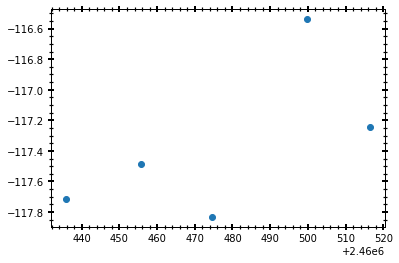

In [21]:
# data['bjd'] = obj_dir[obj]['time']
# data['rv'] = obj_dir[obj]['rv']
# print('mean error originally: %.3f km/s'%np.mean(np.array(obj_dir[obj]['err'])))
# data['rv_err'] = np.array(obj_dir[obj]['err'])#*5
# data['rv_err'] = np.array([error]*len(data['rv']))
plt.scatter(obj_dir[5]['time'],obj_dir[5]['rv'])

In [20]:
ss

NameError: name 'ss' is not defined

In [ ]:
import pickle
program = 'p113'
version = 1

# 2 body
for k in [5]:
    print(k)
#     obj_to_run[k] = [test_tj(k, Pi=40, Pf=1000, chains=2, prior_size=1_000_000, save=False, MCMC=True)]

#     # save mcmc
#     save_dir = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,k,version)
#     with open(save_dir, 'wb') as handle:
#         pickle.dump(obj_to_run[k][0][2], handle, protocol=pickle.HIGHEST_PROTOCOL)

#     # save trace
#     save_dir = '../mcmc/%s/%s_trace_%s.pickle'%(program,k,version)
#     with open(save_dir, 'wb') as handle:
#         pickle.dump(obj_to_run[k][0][-2], handle, protocol=pickle.HIGHEST_PROTOCOL)

#     # save joker samples
#     save_dir = '../mcmc/%s/%s_joker_%s.hdf5'%(program,k,version)
#     obj_to_run[k][0][1][0].write(save_dir, overwrite=True)

# 3 body
'''
version = 1
for k in [19]:
    print(k)
    obj_to_run[k] = [three_body(k, error=0.2, prior_size=1_000_000, save=False, MCMC=True)]
    
    save_dir = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save trace
    save_dir = '../mcmc/%s/%s_trace_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][-2], handle, protocol=pickle.HIGHEST_PROTOCOL)
'''


In [ ]:
max(obj_to_run[23][0][2].tbl.to_pandas()['P'])

In [ ]:
fig = corner.corner(obj_to_run[21][0][2].tbl.to_pandas()[['P','e','omega','M0','K','v0']], 
                            labels=['P','e','omega','M0','K','v0'],
                            quantiles=[0.16, 0.5, 0.84],
                            show_titles=True,
                            title_kwargs={"fontsize": 12}
                           )



In [ ]:
pm.sample?

In [ ]:

obj_to_run = {2:[], 8:[], 10:[], 12:[], 13:[], 14:[], 15:[], 17:[], 18:[], 20:[], 22:[], 24:[], 25:[]}

In [ ]:
binaries_in_113 = 7, 9, 11, 16, 18, 23, 19

In [ ]:
# obj_to_run
program = 'p113'
version = 1
for obj in [9]:
    save_dir = '../mcmc/%s/%s_joker_%s.hdf5'%(program,obj,version)
    print(save_dir)
    obj_to_run[obj][0][1][0].write(save_dir, overwrite=True)


In [ ]:
# RG 9 run with default priors in P and e
ps_9_2body, js_9_2body, ms_9_2body, trace_9_2body, par_names_9_2body = test_tj(9, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)



In [ ]:
# RG 19 run with default priors in P and e
ps_19_2body, js_19_2body, ms_19_2body, trace_19_2body, par_names_19_2body = test_tj(19, error=0.25, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)



In [ ]:
# RG 21 run with default priors in P and e
ps_21_2body, js_21_2body, ms_21_2body, trace_21_2body, par_names_21_2body = test_tj(21, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)



In [ ]:
# RG 1 run with default priors in P and e
ps_1_2body, js_1_2body, ms_1_2body, trace_1_2body, par_names_1_2body = test_tj(1, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)



In [ ]:
# RG 3 run with default priors in P and e
ps_3_2body, js_3_2body, ms_3_2body, trace_3_2body, par_names_3_2body = test_tj(3, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)



In [ ]:
# RG 6 run with default priors in P and e
ps_6_2body, js_6_2body, ms_6_2body, trace_6_2body, par_names_6_2body = test_tj(6, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)



In [ ]:
obj_to_run = {1:[], 2:[], 4:[], 13:[], 24:[]}

In [ ]:
# RG 7 run with default priors in P and e
ps_7_2body, js_7_2body, ms_7_2body, trace_7_2body, par_names_7_2body = test_tj(7, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)



In [ ]:
ss

In [ ]:
# RG 23 run with default priors in P and e
ps_23_2body_s, js_23_2body_s, ms_23_2body_s, trace_23_2body_s, par_names_23_2body_s = test_tj(23, prior_size=2_000_000, save=False, MCMC=True)#,save=True,MCMC=True)



In [ ]:
# RG 23 run with default priors in P and e
ps_23_2body_s, js_23_2body_s, ms_23_2body_s, trace_23_2body_s, par_names_23_2body_s = test_tj(23, prior_size=2_000_000, save=False, MCMC=True)#,save=True,MCMC=True)



In [ ]:
az.summary(trace_23_2body, par_names_23_2body)


In [ ]:
truth = ['P','e','omega','M0','K','v0']
fig = corner.corner(ms_23_2body.tbl.to_pandas()[truth])
fig.show()


In [ ]:
# RG 23 run with default priors in P and e
ps_23_2body, js_23_2body, ms_23_2body, trace_23_2body, par_names_23_2body = test_tj(23, prior_size=2_000_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
# RG 4 run with default priors in P and e
ps_4_2body, js_4_2body, ms_4_2body, trace_4_2body, par_names_4_2body = test_tj(4, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 9 run with default priors in P and e
ps_9_2body, js_9_2body, ms_9_2body, trace_9_2body, par_names_9_2body = test_tj(9, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 23 run with defalt priors in P and e
ps_23, js_23, ms_23, trace_23, par_names_23 = test_tj(23, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 21 run with default priors in P and e
ps_21_2body, js_21_2body, ms_21_2body, trace_21_2body, par_names_21_2body = test_tj(21, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 21 run with default priors in P and e
ps_21, js_21, ms_21, trace_21, par_names_21 = test_tj(21, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 19 run with default priors in P and e
ps_19, js_19, ms_19, trace_19, par_names_19 = test_tj(19, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 19 run with default priors in P and e
ps_19_2body, js_19_2body, ms_19_2body, trace_19_2body, par_names_19_2body = test_tj(19, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 18 run with default priors in P and e
ps_18_2body, js_18_2body, ms_18_2body, trace_18_2body, par_names_18_2body = test_tj(18, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 18 run with default priors in P and e
ps_18, js_18, ms_18, trace_18, par_names_18 = test_tj(18, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 9 run with default priors in P and e
ps_9, js_9, ms_9, trace_9, par_names_9 = test_tj(9, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 5 run with uniform priors in P and e
# 2 body
ps_5_2, js_5_2, ms_5_2, trace_5_2, par_names_5_2 = test_tj(5, prior_size=200_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
az.summary(trace_5_2,par_names_5_2 )

In [ ]:
# RG 4 run with uniform priors in P and e
ps_4_2, js_4_2, ms_4_2, trace_4_2, par_names_4_2 = test_tj(4, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
# RG 4 run with default priors in P and e
ps_4, js_4, ms_4, trace_4, par_names_4 = test_tj(4, prior_size=200_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
2460499.65405186 - 2460454.61560151#obj_dir[4]
az.summary(trace_5_2,par_names_5_2 )

In [ ]:
# RG 5 run with default priors in P and e
ps_5, js_5, ms_5, trace_5, par_names_5 = test_tj(5, prior_size=200_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
az.summary(trace_11_2body, par_names_11_2body)

In [ ]:
ps_11_2body, js_11_2body, ms_11_2body, trace_11_2body, par_names_11_2body = test_tj(11, prior_size=200_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
obj_dir[4]

In [ ]:
# RG 11 run with default priors in P and e
ps_11, js_11, ms_11, trace_11, par_names_11 = test_tj(11, prior_size=200_000, save=False, MCMC=True)#,save=True,MCMC=True)




In [ ]:
# P: uniform, e: uniform
ps_D, js_D, ms_D, trace_D, par_names_D = test_tj(16, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
trace_D

In [ ]:
# P: uniform, e: default
ps_C, js_C, ms_C, trace_C = test_tj(16, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
trace_A

In [ ]:
# P: default, e: uniform
ps_B, js_B, ms_B, trace_B = test_tj(16, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
# P: default, e: default
ps_A, js_A, ms_A, trace_A = test_tj(16, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
ps_8, js_8, ms_8, trace_8 = test_tj(16, prior_size=200_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
trace_7

In [ ]:
trace_6

In [ ]:
ps_7, js_7, ms_7, trace_7 = test_tj(16, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
ps_6, js_6, ms_6, trace_6 = test_tj(16, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
ps_5, js_5, ms_5 = test_tj(16, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
# default prior in e
ps_4, js_4, ms_4 = test_tj(16, prior_size=200_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
# uniform prior in e
ps_3, js_3 = test_tj(16, prior_size=200_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
ps_2, js_2 = test_tj(16, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:

rg16_ps_err_x_10_L, rg16_js_err_x_10_L = test_tj(16, prior_size=200_000, save=False, MCMC=True)#,save=True,MCMC=True)


In [ ]:
ss

In [ ]:
ps_err_x_1, js_err_x_1 = test_tj(18, prior_size=250_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
ps_err_x_10, js_err_x_10 = test_tj(18, prior_size=250_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:
ps_err_x_10_L, js_err_x_10_L = test_tj(18, prior_size=1_000_000, save=False, MCMC=True)#,save=True,MCMC=True)

In [ ]:

_=plt.hist(js[1],bins='auto')
plt.xlabel('Joker Samples')
plt.yscale('log')



In [ ]:
ss

In [ ]:
binaries = [23, 13, 7, 6, 5, 4, 1]
for star_id in binaries[1:]:#list(obj_dir.keys()):
    print(star_id)
    test_tj(star_id, prior_size=250_000, save=True, MCMC=True)#,save=True,MCMC=True)

In [ ]:
ts1, ts2 = test_tj(13,prior_size=50_000,save=False,MCMC=False)

In [ ]:
_=plt.hist(ts1[1],bins='auto')
_=plt.hist(ts2[1],bins='auto')
plt.yscale('log')


In [ ]:
test_tj(13,prior_size=50_000,save=False,MCMC=True)

In [ ]:
test_tj(13,prior_size=2_500_000,save=False,MCMC=True)

In [ ]:
test_tj(13,prior_size=250_000,save=False,MCMC=False)

In [ ]:
test_tj(13,prior_size=250_000,save=False,MCMC=False)

In [ ]:
plt.hist(prior_samples_dict[13]['P'].to_value())


In [ ]:
test_tj(13,prior_size=250_000,save=False,MCMC=False)

In [ ]:
test_tj(13,prior_size=250_000,save=False,MCMC=True)

In [ ]:
prior_samples_dict = dict.fromkeys(obj_dir)
joker_samples_dict = dict.fromkeys(obj_dir)
for ob in list(obj_dir.keys())[1:]:
    ps, js = test_tj(ob,prior_size=250_000,save=False,MCMC=True)
    prior_samples_dict[ob] = ps
    joker_samples_dict[ob] = js
    

In [ ]:
joker_samples_dict[6]

In [ ]:
plt.figure()
for i,param in enumerate(['e', 'omega', 'M0', 's', 'P']):
    plt.subplot(2,3,i+1)
    plt.hist(prior_samples_dict[5][param].to_value())
    plt.title(param)
plt.tight_layout()

plt.figure()
for i,param in enumerate(['e', 'omega', 'M0', 's', 'P','K','v0']):
    plt.subplot(3,3,i+1)
    plt.hist(joker_samples_dict[5][param].to_value())
    plt.title(param)
plt.tight_layout()